## Tiltmeter - ROMYT (with Pot & IsodurBox) Isolation Check

### Import Libraries

In [1]:
import os
import gc
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax, nanmean, array
from pandas import read_csv, DataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__readYaml import __readYaml
from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.smoothing import __smooth
from functions.reduce import __reduce
from functions.converstion_to_tilt import __conversion_to_tilt
from functions.plot_all_tilt import __plot_all_tilt

### Define Functions

### Configurations

In [4]:
config = {}

## decide to store figures
config['save'] = False

## set time period
# config['tbeg'] = UTCDateTime("2024-02-23 12:00")
# config['tend'] = UTCDateTime("2024-03-07 12:00")

config['tbeg'] = UTCDateTime("2024-03-08 12:00")
config['tend'] = UTCDateTime("2024-04-08 00:00")

## specify paths
config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_data'] = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

config['path_to_figs'] = data_path+"tiltmeter/figures/"


## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter.conf")

## correction of offset (e.g. reset mass)
# offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_offsets.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")



### Load Tilt Data

In [5]:
ROMYT0 = __read_sds(config['path_to_sds'], "BW.ROMYT..MA*", config['tbeg'], config['tend'])

ROMYT0 = ROMYT0.sort()

ROMYT0 = ROMYT0.merge(fill_value="interpolate")

# ROMYT0 = ROMYT0.resample(1.0, no_filter=False)

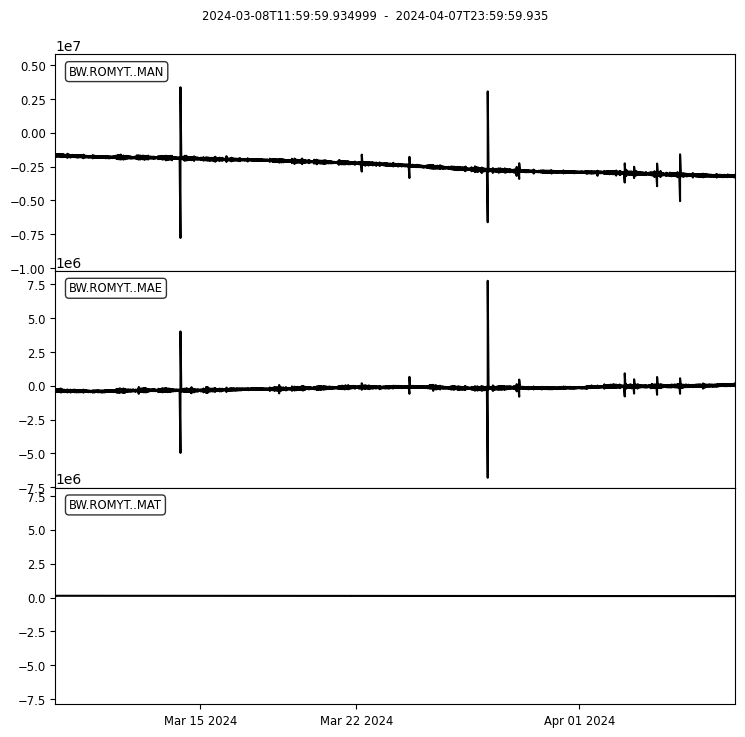

In [6]:
ROMYT0.plot();

In [7]:
gc.collect();

### Covert Data

In [8]:
ROMYT = __conversion_to_tilt(ROMYT0, confTilt['ROMYT'])

  -> converted data of ROMYT


### Load Temperature Data

In [9]:
def __interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array

In [10]:
ps = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.L*", config['tbeg'], config['tend'], data_format="MSEED")

In [11]:
for tr in ps:
    tr.data = __interpolate_nan(tr.data)

In [12]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS7", config['tbeg'], config['tend'])


Specified end: 2024-04-08T00:00:00.000000Z 
Trace end:     2024-04-07T23:59:59.000000Z


In [13]:
## Reset start to Zero
for st in [ROMYT]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= nanmean(tr.data[:200])

In [14]:
htp = read_csv(archive_path+"temp_archive/ROMY_HTP/htp.txt", delimiter=" ")

htp.dropna(inplace=True)

In [15]:

htp['DateTimeUTC'] =  array([UTCDateTime(_t)-3600 for _t in htp.DateTimeT])
htp['time_seconds'] = array([abs(config['tbeg'] - UTCDateTime(str(_t))) for _t in htp.DateTimeUTC])

htp = htp[htp.DateTimeT >= config['tbeg']]
htp = htp[htp.DateTimeT <= config['tend']]

### Plotting

/tmp/ipykernel_117954/766932850.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


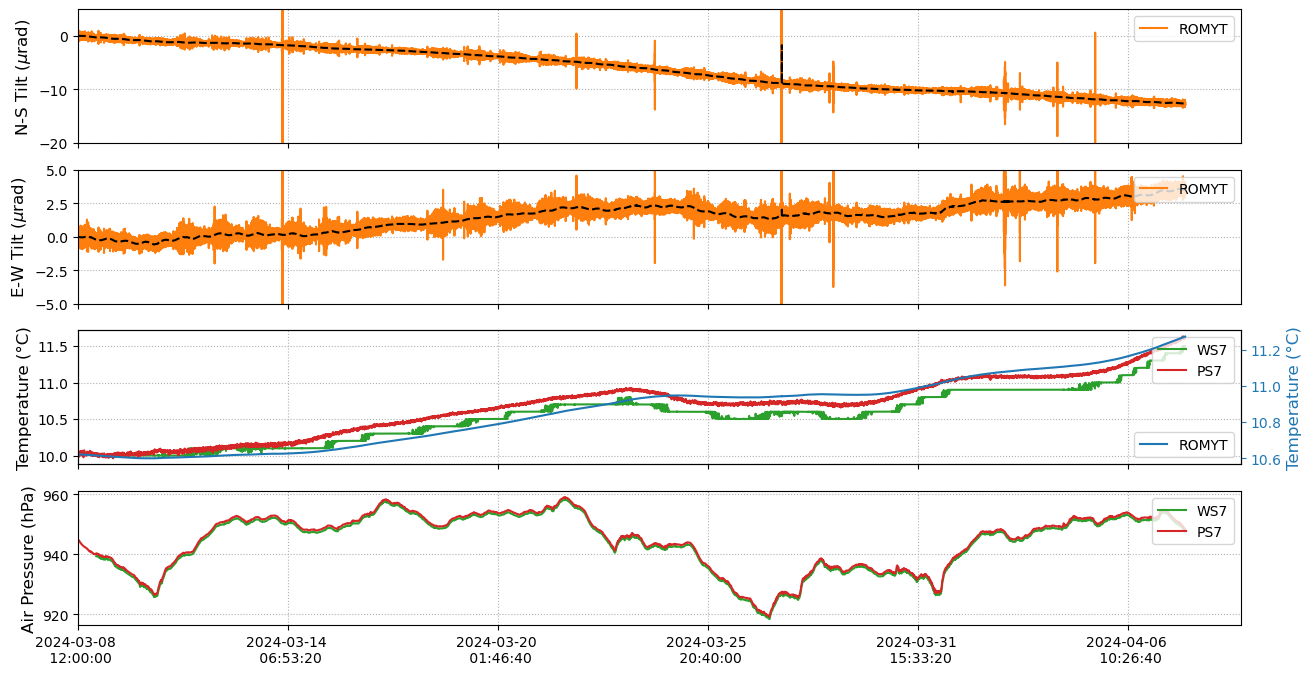

In [16]:
def __makeplot_overview():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    time_scaling = 1
    tilt_scaling = 1e6

    ref_time = config['tbeg']

    # ax[0].plot(TROMY.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
    #            TROMY.select(channel="*N")[0].data*tilt_scaling, label="TROMY", color="tab:blue")

    ax[0].plot(ROMYT.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
               ROMYT.select(channel="*N")[0].data*tilt_scaling, label="ROMYT", color="tab:orange")

    # ax[1].plot(TROMY.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
    #            TROMY.select(channel="*E")[0].data*tilt_scaling, label="TROMY", color="tab:blue")

    ax[1].plot(ROMYT.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
               ROMYT.select(channel="*E")[0].data*tilt_scaling, label="ROMYT", color="tab:orange")

    # ax[0].plot(TROMY.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
    #            __smooth(TROMY.select(channel="*N")[0].data*tilt_scaling, 600), color="k", ls="--")
    ax[0].plot(ROMYT.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ROMYT.select(channel="*N")[0].data*tilt_scaling, 600), color="k", ls="--")
    # ax[1].plot(TROMY.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
    #            __smooth(TROMY.select(channel="*E")[0].data*tilt_scaling, 600), color="k", ls="--")
    ax[1].plot(ROMYT.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ROMYT.select(channel="*E")[0].data*tilt_scaling, 600), color="k", ls="--")

    # ax[2].plot(TROMY.select(channel="*T")[0].times()*time_scaling,
    #            TROMY.select(channel="*T")[0].data, label="TROMY")
    ax22 = ax[2].twinx()
    ax22.plot(ROMYT.select(channel="*T")[0].times(reftime=config['tbeg'])*time_scaling,
              __smooth(ROMYT.select(channel="*T")[0].data, 600), label="ROMYT", color="tab:blue")
    ax22.set_ylabel("Temperature (°C)", fontsize=font, color="tab:blue")
    ax22.ticklabel_format(useOffset=False)
    ax22.xaxis.label.set_color('tab:blue')
    ax22.tick_params(axis='y', colors='tab:blue')
    ax22.legend(loc=4)

    # ax[2].plot(ROMYT.select(channel="*T")[0].times(reftime=config['tbeg'])*time_scaling,
    #            ROMYT.select(channel="*T")[0].data, label="ROMYT", color="tab:orange")

    ax[2].plot(ws.select(channel="*T")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ws.select(channel="*T")[0].data, 600), label="WS7", color="tab:green")

    ax[2].plot(ps.select(channel="*KI")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ps.select(channel="*KI")[0].data, 600), label="PS7", color="tab:red")

    # ax[2].plot(htp.time_seconds*time_scaling,
    #            __smooth(htp.C, 15), label="stick", color="tab:purple")


    ax[3].plot(ws.select(channel="*P")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ws.select(channel="*P")[0].data, 600), label="WS7", color="tab:green")

    ax[3].plot(ps.select(channel="*DI")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ps.select(channel="*DI")[0].data, 600), label="PS7", color="tab:red")

    # ax[3].plot(htp.time_seconds*time_scaling,
    #            __smooth(htp.hPa, 15), label="stick", color="tab:purple")


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        ax[_n].set_xlim(left=0)

    ax[0].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("E-W Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel("Temperature (°C)", fontsize=font)
    ax[3].set_ylabel("Air Pressure (hPa)", fontsize=font)

    # ax[3].set_xlabel(f"Time (days) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_time)+t).date} \n {UTCDateTime(UTCDateTime(ref_time)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    ax[0].set_ylim(-20, 5)
    ax[1].set_ylim(-5, 5)

    plt.show();

    gc.collect()
    return fig

fig = __makeplot_overview();

fig.savefig(config['path_to_figs']+f"Tilt_ROMYT_POT_Isodur_isolation_check.png", format="png", dpi=150, bbox_inches='tight')


In [17]:
gc.collect()

904

### Plot Spectra

In [18]:
st_new = obspy.Stream()

st_new += ROMYT.copy().select(channel="*T")
st_new += ROMYT.copy().select(channel="*N")
st_new += ROMYT.copy().select(channel="*E")

# st_new += TROMY.copy().select(channel="*T")
# st_new += TROMY.copy().select(channel="*N")
# st_new += TROMY.copy().select(channel="*E")

st_new = st_new.split();
st_new.detrend("demean");
st_new.detrend("linear");
st_new.taper(0.01);

# st_new.filter("bandpass", freqmin=1/(25*3600), freqmax=1/(23*3600), corners=4, zerophase=True);
# st_new.filter("bandpass", freqmin=1/(13*3600), freqmax=1/(11*3600), corners=4, zerophase=True);
# st_new.filter("lowpass", freq=0.01, corners=4, zerophase=True);
# st_new.resample(0.02, no_filter=True);

st_new = st_new.merge()


In [ ]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    Nrow, Ncol = 3, 2

    font = 12

    fig, axes = plt.subplots(Nrow, Ncol,figsize=(15, 5), sharex='col')

    plt.subplots_adjust(hspace=0.2)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for ii, tr in enumerate(st):
        if "T" in tr.stats.channel:
            i = 0
        elif "N" in tr.stats.channel:
            i = 1
        else:
            i = 2

        _tr = tr.copy()
        _tr = _tr.detrend("demean")
        _tr = _tr.detrend("linear")
        _tr = _tr.taper(0.01, type="cosine")

        comp_fft = abs(fftpack.fft(_tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/_tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        if "T" in tr.stats.channel:
            axes[i,0].plot(
                            tr.times()/86400,
                            tr.data,
                            # color='black',
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )
        else:
            axes[i,0].plot(
                            tr.times()/86400,
                            tr.data*1e6,
                            # color='black',
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                        ff[1:len(ff)//2],
                        fxx,
                        # color='black',
                        lw=1.0,
        )

        axes[i,1].vlines(1/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)

        axes[Nrow-1,0].set_xlabel("Time (days)")
        axes[Nrow-1,1].set_xlabel("Frequency (Hz)")

        labels = [r'Temperature. (°C)', r'N-S Tilt ($\mu$rad)', r'E-W Tilt ($\mu$rad)']
        axes[i,0].set_ylabel(labels[i])

        axes[0,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.35), ncol=2, framealpha=1.0, fontsize=font-2)

        axes[i,0].ticklabel_format(useOffset=False)


#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#         axes[i,1].set_xlim(1e-5, 0.001)
#         axes[i,1].set_ylim(0,max(fxx[200:]))
    axes[0,1].set_ylabel(r'ASD (°C/$\sqrt{Hz}$)')
    axes[1,1].set_ylabel(r'ASD (rad/$\sqrt{Hz}$)')
    axes[2,1].set_ylabel(r'ASD (rad/$\sqrt{Hz}$)')

    return fig

fig = __makeplotStreamSpectra(st_new, config);

# fig.savefig(config['path_to_figs']+f"Tilt_ROMYT_POT_Isodur_isolation_check_spectra.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
stt = obspy.Stream()

stt += ROMYT.copy()
stt += ps.copy()

for tr in stt:
    if tr.stats.station == "ROMYT" and "T" not in tr.stats.channel:
        tr.data = __reduce(tr.data, 2000)

stt = stt.detrend("simple");

stt = stt.taper(0.01);

fmax = 0.01
stt = stt.filter("lowpass", freq=fmax, corners=4, zerophase=True);

stt = stt.resample(10*fmax, no_filter=True);

# stt.plot(equal_scale=False);

In [ ]:
def __makeplotStreamSpectra(st):

    from scipy import fftpack
    from numpy import abs

    Nrow, Ncol = 4, 2

    font = 12

    fig, axes = plt.subplots(Nrow, Ncol,figsize=(15, 7), sharex='col')

    plt.subplots_adjust(hspace=0.2, wspace=0.15)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for ii, tr in enumerate(st):
        if "T" in tr.stats.channel:
            i = 0
        elif "N" in tr.stats.channel:
            i = 1
        elif "E" in tr.stats.channel:
            i = 2
        elif "D" in tr.stats.channel:
            i = 3
        elif "K" in tr.stats.channel:
            i = 0

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)

        colors = {"ROMYT":"tab:blue", "PROMY":"tab:orange"}

        ## _________________________________________________________________
        if "T" in tr.stats.channel or "K" in tr.stats.channel or "D" in tr.stats.channel:
            axes[i, 0].plot(
                            tr.times()/86400,
                            tr.data,
                            color=colors[tr.stats.station],
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )
        else:
            axes[i, 0].plot(
                            tr.times()/86400,
                            tr.data*1e6,
                            color=colors[tr.stats.station],
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                        1/ff[1:len(ff)//2]/3600,
                        fxx,
                        color=colors[tr.stats.station],
                        lw=1.0,
        )

        axes[i,1].vlines(86400/3600, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(0.5*86400/3600, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)

        axes[Nrow-1,0].set_xlabel("Time (days)")
        # axes[Nrow-1,1].set_xlabel("Frequency (Hz)")
        axes[Nrow-1,1].set_xlabel("Period (hour)")

        labels = [r'$\Delta$Temperature. (°C)', r'N-S Tilt ($\mu$rad)', r'E-W Tilt ($\mu$rad)', r'$\Delta$Pressure (hPa)']
        axes[i,0].set_ylabel(labels[i])

        # axes[i,1].set_ylabel(r'ASD (rad/Hz)')
        axes[0,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.35), ncol=3, framealpha=1.0, fontsize=font-2)

        axes[i,0].grid(axis="both", color="grey", alpha=0.3, zorder=0, ls="--")
        axes[i,1].grid(axis="both", color="grey", alpha=0.3, zorder=0, ls="--")

        axes[i,1].set_xlim((1/fmax/3600), 1e3)

    axes[0,1].set_ylabel(r'ASD (°C/$\sqrt{Hz}$)')
    axes[1,1].set_ylabel(r'ASD (rad/$\sqrt{Hz}$)')
    axes[2,1].set_ylabel(r'ASD (rad/$\sqrt{Hz}$)')
    axes[3,1].set_ylabel(r'ASD (hPa/$\sqrt{Hz}$)')

    return fig

fig = __makeplotStreamSpectra(stt);

fig.savefig(config['path_to_figs']+f"Tilt_ROMYT_POT_Isodur_isolation_check_spectra.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
gc.collect();

## Load STS-2

In [ ]:
from andbro__read_sds import __read_sds

In [ ]:
fur = __read_sds(bay_path+"mseed_online/archive/", "GR.FUR..BH*", config['tbeg'], config['tend'])

fur_inv = obspy.read_inventory(root_path+"/Documents/ROMY/stationxml_ringlaser/dataless/dataless.seed.GR_FUR")

In [ ]:
fur = fur.remove_response(inventory=fur_inv, output="ACC")

fur = fur.merge(fill_value="interpolate")


In [ ]:
stt = obspy.Stream()

stt += ROMYT.copy()
stt += ps.copy()
stt += fur.copy()

for tr in stt:
    if tr.stats.station == "ROMYT" and "T" not in tr.stats.channel:
        tr.data = __reduce(tr.data, 1000)
        tr.data = tr.data*-9.81

# stt = stt.detrend("demean");
stt = stt.detrend("linear");
# stt = stt.detrend("simple");

stt = stt.taper(0.05);

ff = 0.25
stt = stt.filter("lowpass", freq=ff, corners=4, zerophase=True);
stt = stt.resample(2*ff, no_filter=True);

# stt = stt.filter("bandpass", freqmin=1/(30*3600), freqmax=1/(1*3600), corners=4, zerophase=True);
# stt = stt.resample(10*1/(1*3600), no_filter=True);


stt.plot(equal_scale=False);

### Plot Comparison with FUR

In [ ]:
def __makeplot(st0):

    from functions.get_fband_average import __get_fband_average
    from functions.multitaper_coherence import __multitaper_coherence
    from functions.reduce import __reduce
    from functions.get_fft import __get_fft

    dat01 = st0.select(station="ROMYT", channel="*N")[0].data
    dat02 = st0.select(station="ROMYT", channel="*E")[0].data

    dat21 = st0.select(station="FUR", channel="*N")[0].data
    dat22 = st0.select(station="FUR", channel="*E")[0].data


    dt, df = st0[0].stats.delta, st0[0].stats.sampling_rate

    # compute multitaper spectrum
    out01 = __multitaper_coherence(dat01, dat21, dt, n_taper=15, time_bandwidth=3., method=0)

    ff11, psd11 = out01['ff1'][1:], out01['psd1'][1:]
    ff12, psd12 = out01['ff2'][1:], out01['psd2'][1:]
    ff1_coh, coh1 = out01['fcoh'][1:], out01['coh'][1:]

    out02 = __multitaper_coherence(dat02, dat22, dt, n_taper=15, time_bandwidth=3., method=0)

    ff21, psd21 = out02['ff1'][1:], out02['psd1'][1:]
    ff22, psd22 = out02['ff2'][1:], out02['psd2'][1:]
    ff2_coh, coh2 = out02['fcoh'][1:], out02['coh'][1:]

    # compute FFT spectrum
    # ff11, psd11, pha11 = __get_fft(dat01, df)
    # ff12, psd12, pha12 = __get_fft(dat21, df)
    # ff21, psd21, pha21 = __get_fft(dat02, df)
    # ff22, psd22, pha22 = __get_fft(dat22, df)

    # compute average on octave bands
    octa11 = __get_fband_average(ff11, psd11, faction_of_octave=12, fmin=1e-6, average="mean")
    ff11, psd11 = octa11['fcenter'], octa11['psd_means']

    octa12 = __get_fband_average(ff12, psd12, faction_of_octave=12, fmin=1e-6, average="mean")
    ff12, psd12 = octa12['fcenter'], octa12['psd_means']

    octa21 = __get_fband_average(ff21, psd21, faction_of_octave=12, fmin=1e-6, average="mean")
    ff21, psd21 = octa21['fcenter'], octa21['psd_means']

    octa22 = __get_fband_average(ff22, psd22, faction_of_octave=12, fmin=1e-6, average="mean")
    ff22, psd22 = octa22['fcenter'], octa22['psd_means']

    octa_coh1 = __get_fband_average(ff1_coh, coh1, faction_of_octave=12, fmin=1e-6, average="mean")
    ff1_coh, coh1 = octa_coh1['fcenter'], octa_coh1['psd_means']

    octa_coh2 = __get_fband_average(ff2_coh, coh2, faction_of_octave=12, fmin=1e-6, average="mean")
    ff2_coh, coh2 = octa_coh2['fcenter'], octa_coh2['psd_means']

    # ________________________________________________________________________
    # plotting

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = config['tbeg'].date

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12), sharex=False)

    plt.subplots_adjust(hspace=0.25)

    # time_scaling = 1/86400
    time_scaling = 1
    acc_scaling = 1e6

    # ________________________________________________________________________
    #
    ax[0].plot(st0.select(station="ROMYT", channel="*N")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMYT", channel="*N")[0].data*acc_scaling, color="darkblue", label="ROMYT-N", lw=1)

    ax[0].plot(st0.select(station="FUR", channel="*N")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="FUR", channel="*N")[0].data*acc_scaling, color="tab:blue", label="FUR-N", lw=1, ls="--")

    ax[0].plot(st0.select(station="ROMYT", channel="*N")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(st0.select(station="ROMYT", channel="*N")[0].data, 500)*acc_scaling, color="white", lw=1)
    ax[0].plot(st0.select(station="FUR", channel="*N")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(st0.select(station="FUR", channel="*N")[0].data, 500)*acc_scaling, color="white", lw=1, ls="--")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Acc ($\mu$m/s$^2$)", fontsize=font)
    ax[0].legend(loc=1, ncol=4)

    # ________________________________________________________________________
    #
    ax[1].plot(st0.select(station="ROMYT", channel="*E")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMYT", channel="*E")[0].data*acc_scaling, color="darkred", label="ROMYT-E", lw=1)
    ax[1].plot(st0.select(station="FUR", channel="*E")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="FUR", channel="*E")[0].data*acc_scaling, color="tab:red", label="FUR-E", lw=1, ls="--")

    ax[1].plot(st0.select(station="ROMYT", channel="*E")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(st0.select(station="ROMYT", channel="*E")[0].data, 500)*acc_scaling, color="white", lw=1)
    ax[1].plot(st0.select(station="FUR", channel="*E")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(st0.select(station="FUR", channel="*E")[0].data, 500)*acc_scaling, color="white", lw=1, ls="--")

    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Acc ($\mu$m/s$^2$)", fontsize=font)
    ax[1].legend(loc=4, ncol=4)


    # ________________________________________________________________________
    #
    ax[2].plot(ff11, psd11, color="darkblue", label="ROMYT-N")
    ax[2].plot(ff12, psd12, color="tab:blue", label="FUR-N", ls="--")
    ax[2].plot(ff21, psd21, color="darkred", label="ROMYT-E")
    ax[2].plot(ff22, psd22, color="tab:red", label="FUR-E", ls="--")

    ax[2].axvline(1/86400, min(out01['psd1'][1:]), max(out01['psd1'][1:]), color="grey", alpha=0.7, zorder=1)
    ax[2].axvline(2/86400, min(out01['psd1'][1:]), max(out01['psd1'][1:]), color="grey", alpha=0.7, zorder=1)

    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[2].legend(loc=1, ncol=4)
    ax[2].set_ylabel(f"PSD (m$^2$/s$^4$/Hz)", fontsize=font)

    # _______________________________________________________________________
    #
    ax[3].plot(ff1_coh, coh1, color="tab:blue", label="N")
    ax[3].plot(ff2_coh, coh2, color="tab:red", label="E")

    # ax[3].plot(out01['fcoh'][1:], __smooth(out01['coh'][1:], 200), color="k", lw=0.5)
    # ax[3].plot(out02['fcoh'][1:], __smooth(out02['coh'][1:], 200), color="k", lw=0.5, ls="--")

    ax[3].axvline(1/86400, 0, 1.1, color="grey", alpha=0.7, zorder=1)
    ax[3].axvline(2/86400, 0, 1.1, color="grey", alpha=0.7, zorder=1)

    ax[3].set_xscale("log")
    ax[3].set_ylabel("Coherence", fontsize=font)
    ax[3].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[3].set_ylim(0, 1.1)
    ax[3].legend(loc=4, ncol=1)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].set_xlim(left=0)



    # add dates to x-axis
    tcks = ax[0].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[0].set_xticklabels(tcklbls, fontsize=font-3)
    tcks = ax[1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[1].set_xticklabels(tcklbls, fontsize=font-3)


    # add labels for subplots
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    # set axis limits
    ax[0].set_ylim(-10, 10)
    ax[1].set_ylim(-10, 10)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot(stt)

# fig.savefig(config['path_to_figs']+f"Tilt_ROMYT_POT_Isodur_FUR_spectra.png", format="png", dpi=150, bbox_inches='tight')
